In [19]:
import requests 
from requests.auth import HTTPBasicAuth
import json 
import numpy as np
import pandas as pd

In [20]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [21]:
api_key = "94d15fb2-75c4-4439-97bb-9927089c6698"
server_url = 'https://esgf-server-staging.herokuapp.com'
service_name = 'get_inference_data'
params = f"?api_key={api_key}"
headers = {
       'Accept': 'application/json',
       'Authorization' : f"Bearer {api_key}"
}
response = requests.get(f"{server_url}/{service_name}{params}", headers=headers)
print(response.text)
assert response.status_code == 200

{"id":"cGIG358IM97cnNab","x":"{\"wconfid\":{\"0\":1,\"1\":1,\"2\":1,\"3\":1,\"4\":1,\"5\":1,\"6\":1,\"7\":1,\"8\":1,\"9\":1,\"10\":1,\"11\":1,\"12\":1,\"13\":1,\"14\":1,\"15\":1,\"16\":1,\"17\":1,\"18\":1,\"19\":1,\"20\":1,\"21\":1,\"22\":1,\"23\":1,\"24\":1,\"25\":1,\"26\":1,\"27\":1,\"28\":1,\"29\":1,\"30\":1,\"31\":1},\"pctid\":{\"0\":30,\"1\":30,\"2\":30,\"3\":30,\"4\":30,\"5\":30,\"6\":30,\"7\":30,\"8\":30,\"9\":30,\"10\":30,\"11\":30,\"12\":30,\"13\":30,\"14\":30,\"15\":30,\"16\":30,\"17\":30,\"18\":30,\"19\":30,\"20\":30,\"21\":30,\"22\":30,\"23\":30,\"24\":30,\"25\":30,\"26\":30,\"27\":30,\"28\":30,\"29\":30,\"30\":30,\"31\":30},\"x\":{\"0\":0.953,\"1\":0.996,\"2\":1.004,\"3\":1.008,\"4\":1.016,\"5\":1.023,\"6\":1.027,\"7\":1.004,\"8\":0.984,\"9\":1.012,\"10\":1.055,\"11\":1.023,\"12\":1.023,\"13\":1.008,\"14\":1.02,\"15\":1.043,\"16\":0.98,\"17\":0.953,\"18\":1.047,\"19\":1.004,\"20\":0.98,\"21\":1.012,\"22\":1.004,\"23\":1.016,\"24\":1.016,\"25\":1.008,\"26\":0.977,\"27\":0.9

Sample

In [22]:
# Server answer as json. Dictionary with keys 'id' and 'x'
json_answer = response.json()

# Example id
example_id = json_answer['id']

# Parse str answer as json object
json_answer = json.loads(json_answer['x'])

# Frame answer
pd_sample = pd.DataFrame(json_answer)

# Logs. You should have (32,5).
print("Sample ID='{}' has shape {}".format(example_id, pd_sample.shape))

Sample ID='cGIG358IM97cnNab' has shape (32, 5)


In [23]:
pd_sample

,wconfid,pctid,x,y,z
0,1,30,0.953,0.012,-0.133
1,1,30,0.996,0.012,-0.113
2,1,30,1.004,0.082,-0.145
3,1,30,1.008,0.012,-0.113
4,1,30,1.016,0.086,-0.141
5,1,30,1.023,0.031,-0.117
6,1,30,1.027,-0.008,-0.145
7,1,30,1.004,-0.043,-0.121
8,1,30,0.984,0.012,-0.121
9,1,30,1.012,0.043,-0.129


In [24]:
print(pd_sample.shape)  # (32, 5)
pd_sample.tail()
     

(32, 5)


,wconfid,pctid,x,y,z
27,1,30,0.996,-0.051,-0.109
28,1,30,0.961,0.016,-0.145
29,1,30,1.023,0.047,-0.129
30,1,30,0.980,0.059,-0.105
31,1,30,1.008,0.000,-0.148


In [25]:
macro_data = pd_sample[['x','y','z']]
print(macro_data.shape)

(32, 3)


In [26]:
train_df=macro_data[:-12]
test_df=macro_data[-12:]

In [27]:
print(test_df.shape)

(12, 3)


In [28]:
model = VAR(train_df.diff()[1:])

In [29]:
sorted_order=model.select_order(maxlags=3)
print(sorted_order.summary())


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -19.04      -18.90   5.372e-09      -19.04
1      -19.26      -18.68   4.446e-09      -19.23
2      -21.93     -20.92*  3.616e-10*      -21.88
3     -22.06*      -20.61   5.046e-10     -21.98*
-------------------------------------------------


In [30]:
var_model = VARMAX(train_df, order=(4,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                           Statespace Model Results                           
Dep. Variable:        ['x', 'y', 'z']   No. Observations:                   20
Model:                         VAR(4)   Log Likelihood                 147.223
                          + intercept   AIC                           -204.445
Date:                Thu, 23 Feb 2023   BIC                           -159.637
Time:                        12:23:48   HQIC                          -195.698
Sample:                             0                                         
                                 - 20                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):       0.34, 0.55, 0.04   Jarque-Bera (JB):      2.29, 0.98, 2.20
Prob(Q):                  0.56, 0.46, 0.84   Prob(JB):              0.32, 0.61, 0.33
Heteroskedasticity (H):   0.50, 0.17, 4.88   Skew:               -0.63, -0.03, -0.80
Prob(H) (two-sided):      0.38, 0.

In [31]:
n_forecast = 300
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)

predictions=predict.predicted_mean


In [32]:
predictions.columns=['x_predicted','y_predicted','z_predicted']
predictions

,x_predicted,y_predicted,z_predicted
20,1.010223,0.007212,-0.133812
21,1.023455,0.024188,-0.140054
22,0.993724,0.011060,-0.112822
23,1.015815,0.007435,-0.140336
24,1.017741,0.008141,-0.125477
...,...,...,...
315,1.009235,0.010437,-0.129446
316,1.009235,0.010437,-0.129446
317,1.009235,0.010437,-0.129446
318,1.009235,0.010437,-0.129446


***" t= 32	     //          x= 0.972211	  //               y=0.002333	      //               z =-0.112556"***

In [33]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)

<AxesSubplot:>

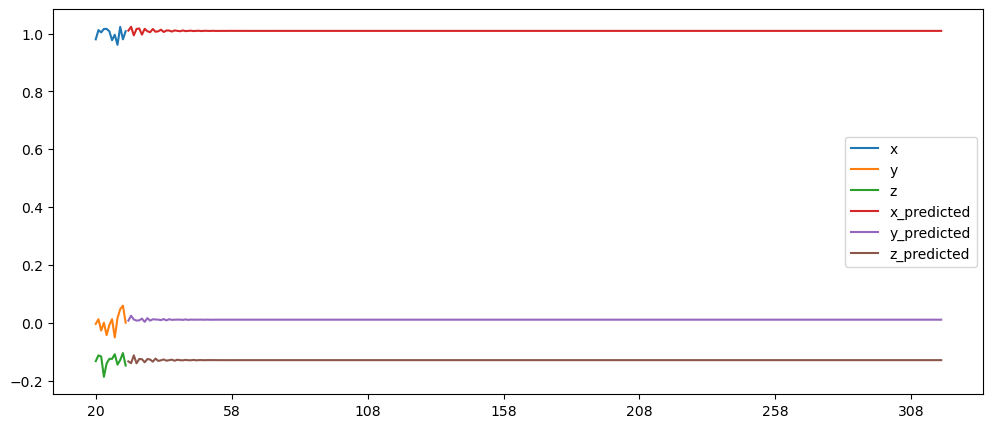

In [34]:
test_vs_pred.plot(figsize=(12,5))

***" t= 32	     //          x= 0.972211	  //               y=0.002333	      //               z =-0.112556"***

In [35]:
#https://esgf-server-staging.herokuapp.com/predict?api_key=94d15fb2-75c4-4439-97bb-9927089c6698&example_id=2vYbLYtMfXTkPpKe&prediction=0.972211,0.002333,-0.112556

In [36]:
api_key = "94d15fb2-75c4-4439-97bb-9927089c6698"
server_url = 'https://esgf-server-staging.herokuapp.com'
example_id ="2vYbLYtMfXTkPpKe"
prediction="0.972211,0.002333,-0.112556"
service_name = 'predict'
params = f"?api_key={api_key}&example_id={example_id}&prediction={prediction}"
headers = {
       'Accept': 'application/json',
       'Authorization' : f"Bearer {api_key}"
}
response = requests.get(f"{server_url}/{service_name}{params}", headers=headers)
print(response.text)
assert response.status_code == 200

{"rmse_example":0.038435351205103455,"submissions":1,"remaining":499}
